In [222]:
import preprocess
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")

### Some functions we might need

In [223]:
def prepre(df):
    df = df.drop(['Date of Discharge', 'Chronic disease',
           'Immune status', 'Foley days', 'CVC days', 'Palliative', 'PH', 
           'Vent days', 'TWA Glucose', 'LOS', 'APACHE II Pred Mort', 'Trop Pred Mort'], axis=1)
    df['Vent mode'] = np.nan
    df['A-a gradient'] = np.nan
    df = df[['Unnamed: 0.1', 'Name', 'CPMRN', 'Date of admission', 'Age', 'Gender',
           'Hospital', 'Surgical status', 'Vent mode', 'GCS', 'Temperature', 'HR', 
            'SpO2', 'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient', 
            'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Cr', 'Ur', 'T.Bili', 'Urine output',
           'Lactate', 'INR', 'DC Dispo']]
    set_col_names = ['Unnamed: 0', 'Name', 'CPMRN', 'Month of Admission', 'Age', 'Gender',
           'Hospital', 'Surgery', 'Vent mode', 'GCS', 'Temparature', 'HR', 'SpO2',
           'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient',
           'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Serum Cr', 'Blood Urea',
           'Bili', 'Urine output', 'Lactate', 'INR', 'Survival']
    df.columns = set_col_names
    return df

In [224]:
def selectRows(df, col_name, value_list):
    for i in range(len(value_list)):
        if (i==0):
            temp = df[df[col_name]==value_list[i]]
        else:
            new = df[df[col_name]==value_list[i]]
            temp = pd.concat((new, temp), axis=0, ignore_index=True)
    return temp

## Importing datasets 

### Preprocessing and Splitting dataset to train and holdout

In [225]:
df =  pd.read_csv('/home/dileep/Desktop/python/All_csvs/CP_2018-19_data1.csv', index_col=0)

In [226]:
df['DC Dispo'] = df['DC Dispo'].fillna(df['DC Dispo'].value_counts().index[0])
for i in range(df.shape[0]):
    if (df.iloc[i, 12] == 'yes'):
        df.iloc[i,11]='Death'
df['DC Dispo'] = df['DC Dispo'].replace(['Discharged to home/self care AGAINST medical advice (DAMA)', 
         'Discharged to home/self care as per medical advice', 
         'Discharged to ward/floor', 
         'Discharged to Intermediate Care Unit/High Dependency Unit (HDU)', 
         'Discharged to other ICU within the same hospital', 
         'Discharged to higher centre of care',
         'Discharged to another facility', 
         'Death'],['Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Expired'])
df1 = prepre(df)
df1 = df1.loc[~df1.index.duplicated(keep='first')]

In [227]:
pred, targ = preprocess.getFinal(df1).process()

In [228]:
pred_train, pred_h, targ_train, targ_h = train_test_split(pred, targ, test_size=0.15, stratify=targ, random_state=64)

### Extracting Trop and Apache from datasets

In [229]:
apache = df['APACHE II Pred Mort']
trop = df['Trop Pred Mort']

In [230]:
ap_train, ap_h, targ_train, targ_h = train_test_split(apache, targ, test_size=0.15, stratify=targ, random_state=64)
trop_train, trop_h, targ_train, targ_h = train_test_split(trop, targ, test_size=0.15, stratify=targ, random_state=64)

In [231]:
ap_train = ap_train.fillna(0)
trop_train = trop_train.fillna(0)
print(ap_train.isnull().sum())
print(trop_train.isnull().sum())

0
0


In [232]:
apache_trop = [trop_train, ap_train, targ_train]

In [233]:
apache_trop_h = [trop_h, ap_h, targ_h]

# Training Models
We have created following datasets <br>
* pred_train, targ_train <br>
* pred_h, targ_h <br>
* trop_train, targ_train <br>
* trop_h, targ_h <br>
* ap_train, targ_train <br>
* ap_h, targ_h 

In [234]:
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
import xgboost as xgb

SEED = 62

# Creating pipes
pipe_lr = Pipeline(steps=[('clf', LogisticRegression(random_state=42))])
pipe_rf = Pipeline(steps=[('clf', RandomForestRegressor(random_state=42))])
pipe_gb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_sgb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_xgb = Pipeline(steps=[('clf', xgb.XGBRegressor())])

# Creating params
params_lr = {
    'clf__C' : [0.001, 0.01, 0.1, 1],
    'clf__penalty' : ['l1', 'l2']
}
params_rf = {
    'clf__max_depth' : np.arange(2, 20, 6),
    'clf__max_leaf_nodes': np.arange(2,20,6), 
    'clf__min_impurity_split': [0.01, 0.1],
    'clf__n_estimators': np.arange(50, 70, 10)
}
params_gb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4]
}
params_sgb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4], 
    'clf__subsample': [0.8], 
    'clf__max_features': [0.2]
}
params_xgb = {
    'clf__subsample': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3,20,1),
    'clf__colsample_bytree': np.arange(.1,1.05,.05) 
}


# Construct grid searches
jobs = -1

gs_lr = RandomizedSearchCV(estimator=pipe_lr, 
                    param_distributions=params_lr,
                    n_iter=5,
                    scoring='roc_auc',
                    cv=5)
grid_rf = RandomizedSearchCV(estimator=pipe_rf, 
                      param_distributions=params_rf, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_gb = RandomizedSearchCV(estimator=pipe_gb, 
                      param_distributions=params_gb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_sgb = RandomizedSearchCV(estimator=pipe_sgb, 
                      param_distributions=params_sgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_xgb = RandomizedSearchCV(estimator=pipe_xgb, 
                      param_distributions=params_xgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)

# List of pipelines
grids = [grid_sgb, grid_gb, grid_rf, gs_lr, grid_xgb, 1]

# Dictionary of pipelines
grid_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RandomForestRegressor', 
             3: 'Logistic Regression', 4: 'XGBoost', 5: 'Neural Net'}

# Fitting
print('Performing model optimizations...')

X_train, X_test, y_train, y_test = train_test_split(pred_train, targ_train, test_size=0.3, stratify=targ_train, random_state=62)

for idx, gs in enumerate(grids):
    if (grid_dict[idx] == 'Neural Net'):
        print('\nEstimator: %s' % grid_dict[idx])
        
        # Creating NN model
        nn_model = Sequential()
        nn_model.add(Dense(128, activation='relu', input_shape=(24,)))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
        nn_model.add(Dense(1))
        # Compiling
        nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        
        nn_model.fit(pred_train, targ_train)
        y_pred_nn = nn_model.predict(pred_train)
        # Scoring
        print('Train set accuracy score for best param: %.3f ' % roc_auc_score(targ_train, y_pred_nn))
        break
    else:
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        if (grid_dict[idx] == 'Logistic Regression'):
            y_pred = gs.predict_proba(X_test)[:, 1]
        else:
            # Predict on test data with best params
            y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % roc_auc_score(y_test, y_pred))

Performing model optimizations...

Estimator: Stochastic Gradient Boost
Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 20, 'clf__max_features': 0.2, 'clf__max_depth': 4, 'clf__learning_rate': 0.1}
Best training accuracy: 0.771
Test set accuracy score for best params: 0.782 

Estimator: Gradient Boost
Best params: {'clf__n_estimators': 20, 'clf__max_depth': 4, 'clf__learning_rate': 0.1}
Best training accuracy: 0.763
Test set accuracy score for best params: 0.781 

Estimator: RandomForestRegressor
Best params: {'clf__n_estimators': 50, 'clf__min_impurity_split': 0.01, 'clf__max_leaf_nodes': 8, 'clf__max_depth': 8}
Best training accuracy: 0.750
Test set accuracy score for best params: 0.771 

Estimator: Logistic Regression
Best params: {'clf__penalty': 'l2', 'clf__C': 0.1}
Best training accuracy: 0.778
Test set accuracy score for best params: 0.793 

Estimator: XGBoost
[17:39:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarede

In [235]:
models = [grid_sgb.best_estimator_, grid_gb.best_estimator_, grid_rf.best_estimator_, 
          gs_lr.best_estimator_, grid_xgb.best_estimator_, nn_model]

##  Evaluating Models

### AUROCs in train, test and holdout

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8749605257963922
Confidence interval for the score: [0.850 - 0.9]
Optimal threshold in training set is: 0.138
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.8841520941065015
Confidence interval for the score: [0.861 - 0.907]
Optimal threshold in training set is: 0.095
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8368560770536455
Confidence interval for the score: [0.810 - 0.862]
Optimal threshold in training set is: 0.067
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8069810129080647
Confidence interval for the score: [0.780 - 0.834]
Optimal threshold in training set is: 0.091
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.9636294556507323
Confidence interval for the score: [0.953 - 0.97

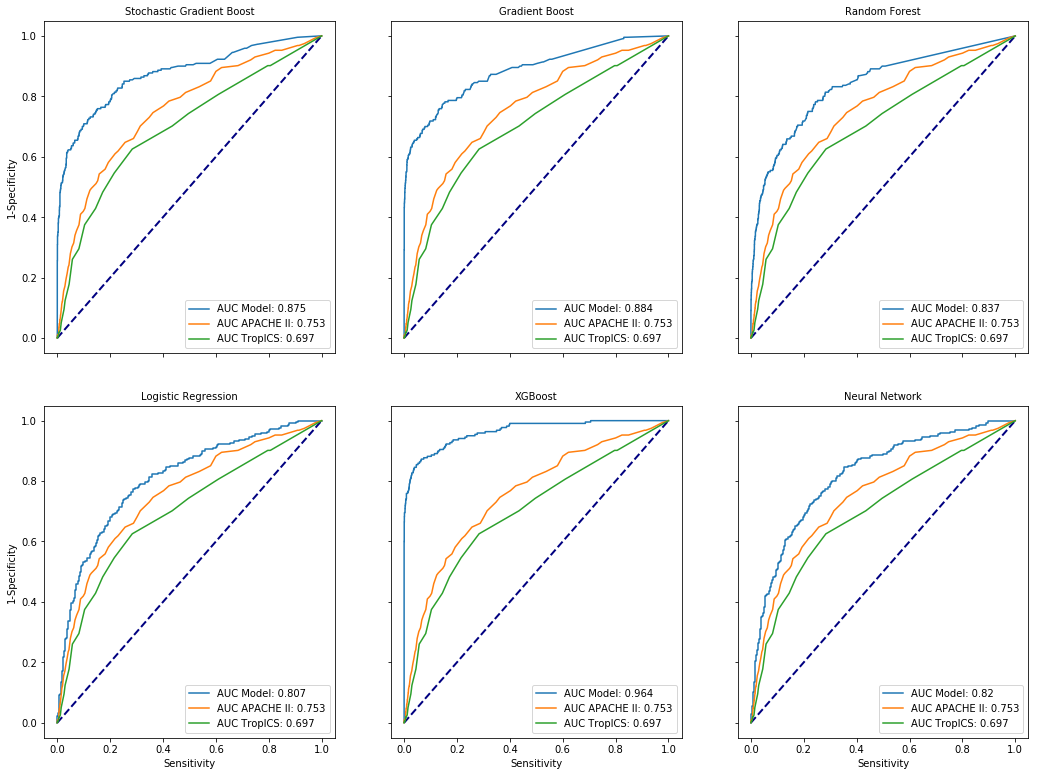

In [236]:
case_tr = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='train', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.781629605929718
Confidence interval for the score: [0.738 - 0.823]
Optimal threshold in training set is: 0.088
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.7805791073428252
Confidence interval for the score: [0.738 - 0.821]
Optimal threshold in training set is: 0.14
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7710339678984696
Confidence interval for the score: [0.724 - 0.815]
Optimal threshold in training set is: 0.07
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.7930677758225351
Confidence interval for the score: [0.750 - 0.831]
Optimal threshold in training set is: 0.098
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.741001439769637
Confidence interval for the score: [0.689 - 0.789]

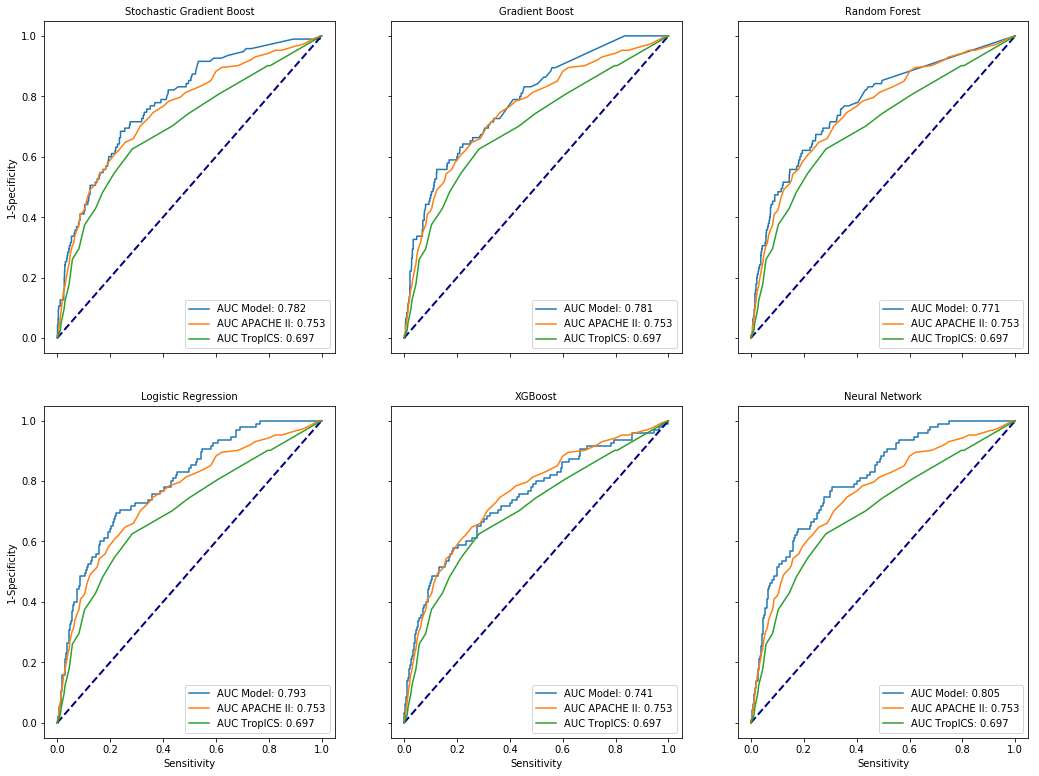

In [237]:
case_tr = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='test', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.812023604622572
Confidence interval for the score: [0.762 - 0.862]
Optimal threshold in training set is: 0.084
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.7789679124661913
Confidence interval for the score: [0.722 - 0.838]
Optimal threshold in training set is: 0.079
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7620635603639047
Confidence interval for the score: [0.702 - 0.826]
Optimal threshold in training set is: 0.105
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8151278583722646
Confidence interval for the score: [0.764 - 0.864]
Optimal threshold in training set is: 0.099
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.7914002950577821
Confidence interval for the score: [0.737 - 0.8

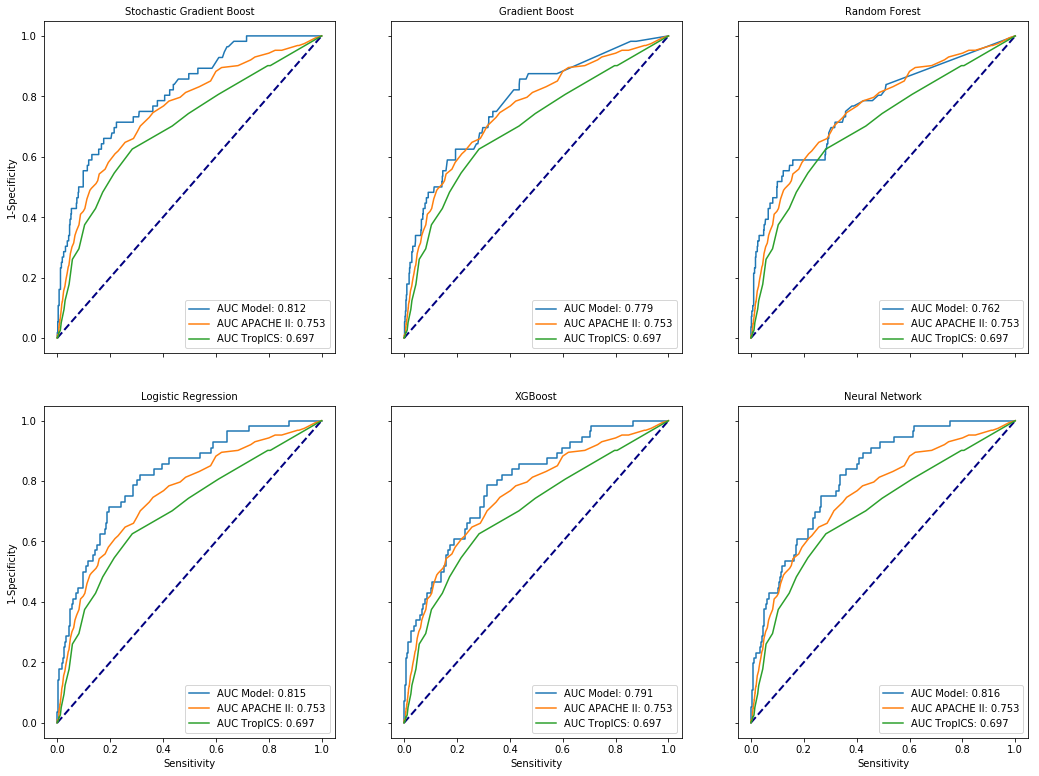

In [238]:
case_tr = preprocess.evaluate(pred_h, targ_h).testPerformance(data_type='holdout', 
                                                              models=models, ap_tr_list=apache_trop)

### Calibration in train and holout

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


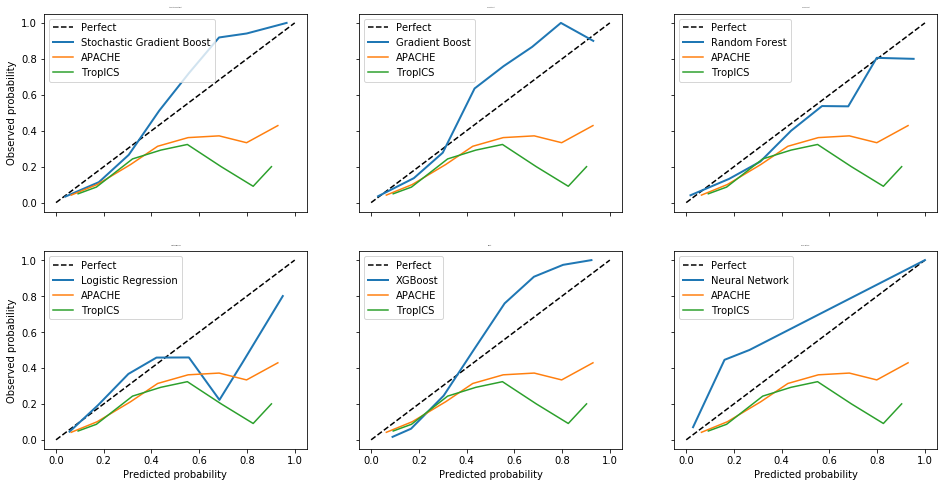

In [239]:
calib_ls_tr = preprocess.Calibration_curves(pred_train, targ_train, data_type='train', 
                              models=models, ap_tr_list=apache_trop).getCalibCurves()

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


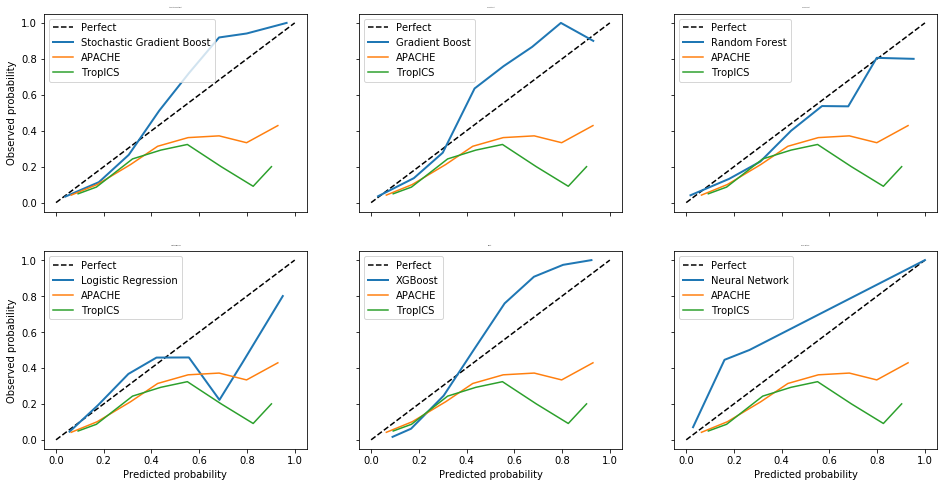

In [240]:
calib_ls_ts = preprocess.Calibration_curves(pred_train, targ_train, data_type='test', 
                              models=models, ap_tr_list=apache_trop).getCalibCurves()

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


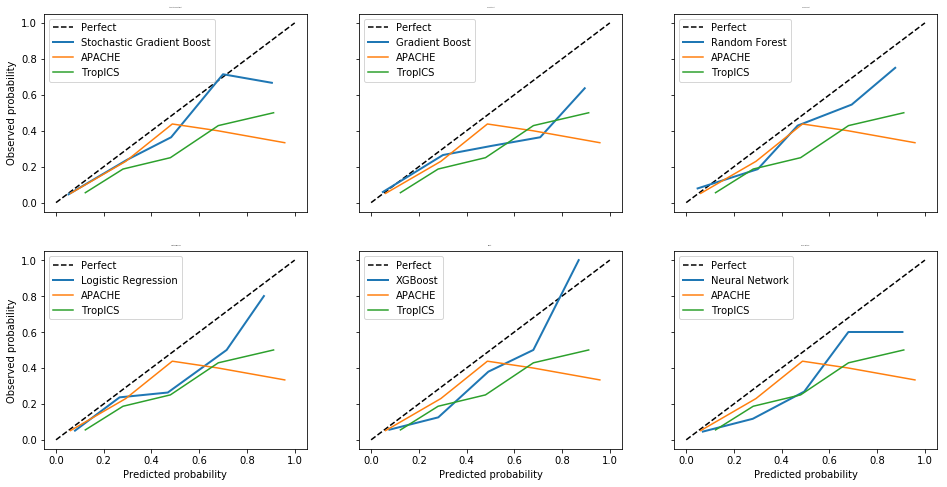

In [241]:
calib_ls_holdout = preprocess.Calibration_curves(pred_h, targ_h, data_type='holdout', 
                              models=models, ap_tr_list=apache_trop_h).getCalibCurves()